## Types of Prompts for PaliGemma

1. **Describe**

  `describe en`

  `What color are the flowers? \n`

  `What is the name of this flower? \n`

2. **Object Detection**

  `detect train\n`
  
  (requires parser functions for understanding output - check [here](https://www.kaggle.com/code/fchollet/paligemma-intro-captioning-vqa-detection-ocr) )

3. **Segmentation**

  `segment {class}\n`

4. **OCR**

  `ocr\n`



## `google/paligemma-3b-pt-896`

In [1]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import requests
import torch

In [2]:
model_id = "google/paligemma-3b-mix-224"
device = "cuda:0"
dtype = torch.bfloat16

In [17]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [22]:
image2 = Image.open('image (2).jpg')

In [28]:
image3 = Image.open('IMG_1650.jpeg')

In [44]:
image4 = Image.open('IMG_1647.jpeg')

In [20]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
).eval()

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [10]:
processor = AutoProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

### **Captioning**

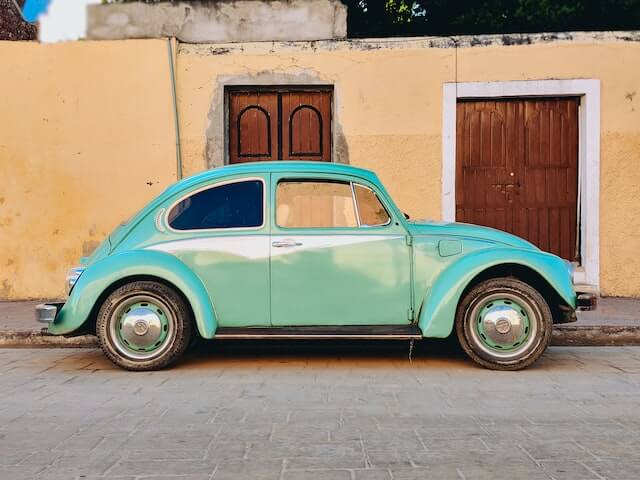

In [21]:
image

In [13]:
# Instruct the model to create a caption in Spanish
prompt = "caption en"
model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

In [14]:
with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

In this image we can see a car on the road. In the background there is a wall, door, trees and sky.


### **OCR**

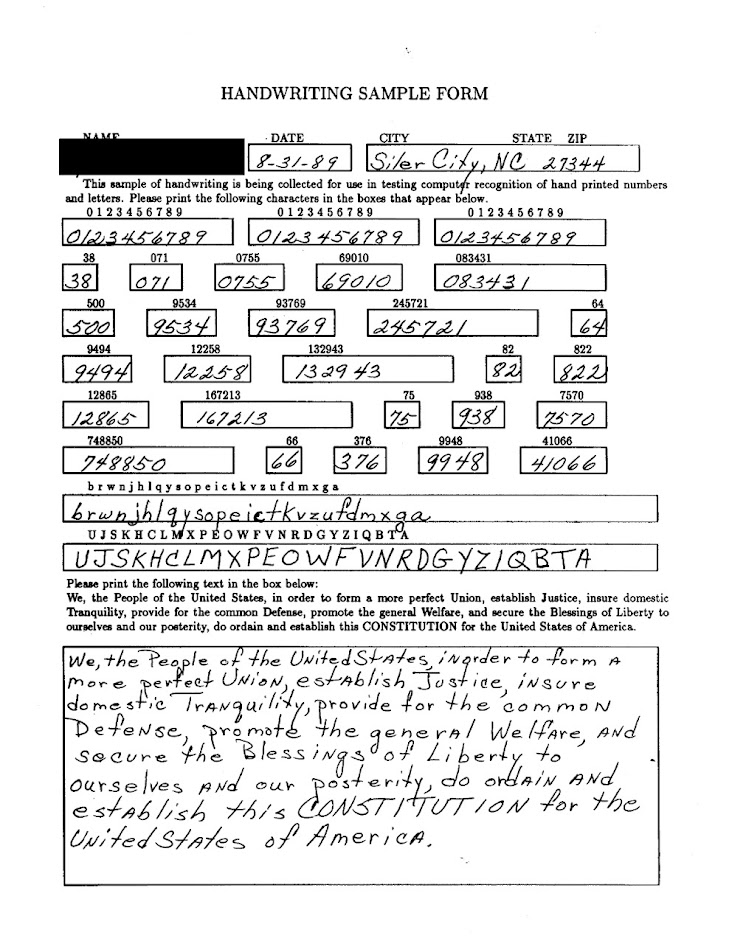

In [24]:
image2

In [26]:
# Instruct the model to create a caption in Spanish
prompt = "ocr\n"
model_inputs = processor(text=prompt, images=image2, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

In [27]:
with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=200, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

HANDWRITING SAMPLE FORM
STATE: WV
CITY:
NAME:
2011
Date:
I am not a member of any political party and I am not aware of any political activity. I am not a member of any political party and I am not aware of any political activity. I am not a member of any political party and I am not aware of any political activity. I am not a member of any political party and I am not aware of any political activity. I am not a member of any political party and I am not aware of any political activity. I am not a member of any political party and I am not aware of any political activity. I am not a member of any political party and I am not aware of any political activity. I am not a member of any political party and I am not aware of any political activity. I am not a member of any political party and I am not aware of any political activity. I am not a member of


### **Detection**

In [32]:
# Instruct the model to create a caption in Spanish
prompt = "detect spoon\n"
model_inputs = processor(text=prompt, images=image3, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

In [33]:
with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=200, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

<loc0159><loc0285><loc0302><loc0809> spoon


In [38]:
import matplotlib.pyplot as plt
import keras
import re
import matplotlib.patches as patches
import numpy as np

In [42]:
def parse_bbox_and_labels(detokenized_output):
    matches = re.finditer(
        '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
        ' (?P<label>.+?)( ;|$)',
        detokenized_output,
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
        labels.append(d['label'])
    return np.array(boxes), np.array(labels)

def display_boxes(image, boxes, labels):
    h, l = image.size[1], image.size[0]
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis("off")
    for i in range(boxes.shape[0]):
        y, x, y2, x2 = boxes[i] * [h, l, h, l]
        width = x2 - x
        height = y2 - y
        # Create a Rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        # Add label
        plt.text(x, y, labels[i], color='red', fontsize=12)
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

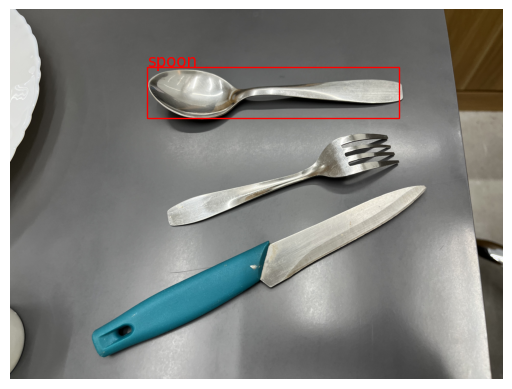

In [43]:
display_boxes(image3, *parse_bbox_and_labels(decoded))

In [46]:
# Instruct the model to create a caption in Spanish
prompt = "detect spoon\n"
model_inputs = processor(text=prompt, images=image4, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

In [47]:
with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=200, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

<loc0560><loc0609><loc0966><loc0702> spoon ; <loc0397><loc0393><loc0818><loc0469> spoon ; <loc0223><loc0132><loc0598><loc0212> spoon


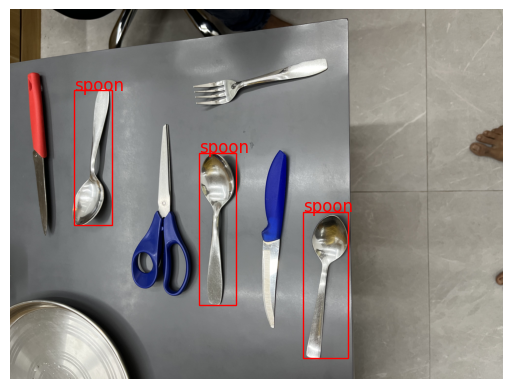

In [49]:
display_boxes(image4, *parse_bbox_and_labels(decoded))

In [83]:
# Instruct the model to create a caption in Spanish
prompt = "detect spoon, fork, knife\n"
model_inputs = processor(text=prompt, images=image4, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

In [84]:
with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=200, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

<loc0129><loc0384><loc0274><loc0656> fork, knife ; <loc0560><loc0609><loc0966><loc0701> spoon ; <loc0409><loc0393><loc0823><loc0464> spoon ; <loc0209><loc0130><loc0593><loc0212> spoon ; <loc0199><loc0000><loc0616><loc0084> knife ; <loc0384><loc0513><loc0887><loc0574> knife ; <loc0337><loc0253><loc0792><loc0368> knife


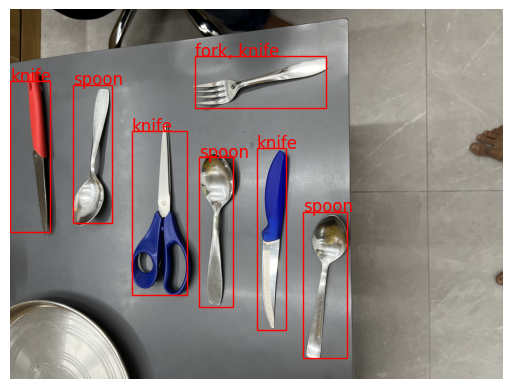

In [85]:
display_boxes(image4, *parse_bbox_and_labels(decoded))

## Model can be finetuned for better results.
Check the following notebooks for finetuning:
1. https://github.com/roboflow/notebooks/blob/main/notebooks/how-to-finetune-paligemma-on-detection-dataset.ipynb

2. https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma
